# **Bank of Italy (Asia-Pacific)-API & OpenAI integrated text software**

Author: Elia Landini______Edition: Alpha______AI version: OpenAI 3.5

### **Preliminary steps**

In [214]:
!pip install openai
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install reportlab
!pip install schedule
!pip install requests-html
!pip install jpstat
!pip install wbgapi
!pip install fredapi


### **Data Import**

##### 1) e-Stat: Japanese Goverment Statistics 

1.0) Jpstat API package settings

In [6]:
import os
import pandas as pd
from requests_html import HTMLSession
import jpstat
import json
import sys

In [7]:
# Function: scrape_stat
# helper functions (jpstat) to get the list of the available macro-variables' ID on e-Stat
# the @ID column does not provide what will be lately called "statsDataId" into the get_data function

def scrape_stat():
    url_base = 'https://www.e-stat.go.jp/en/stat-search/files?page=1'
    def url_info_base(
        x): return f"https://www.e-stat.go.jp/retrieve/api_file_modal?params[filters][toukei_cd]={x}&params[depth]=1&params[lang]=en"

    session = HTMLSession()
    r = session.get(url_base)
    page_info = r.html.find(".stat-paginate-index", first=True)
    if page_info:
        pages = int(page_info.text[2:-3])
    else:
        pages = 1

    stats = []

    for p in range(pages):
        url = url_base[:-1] + str(p+1)
        r = session.get(url)

        tables = r.html.find(".stat-search_result-item1-main")
        for t in tables:
            d = {}
            d["@id"] = t.find(".stat-toukei_code_items > .stat-title", first=True).text
            d["STAT_NAME"] = t.find(".stat-toukei_name_items > .stat-title", first=True).text
            if t.find(".fa.fa-info", first=True):
                url_info = url_info_base(d["@id"])
                r = session.get(url_info)
                info = json.loads(r.html.text)
                d["GOV_ORG"] = info["kikan_kashitsu"]
                d["EXPLANATION"] = info["explanation"]
                d["HP_URL"] = info["exp_url"]

            stats.append(d)

        sys.stdout.write(".")
        sys.stdout.flush()

    df = pd.DataFrame(stats)
    return df
dfstat = scrape_stat()
print(dfstat)

.         @id                                          STAT_NAME
0   00100406                     Indexes of Business Conditions
1   00100409                                  National Accounts
2   00130002                      Statistics about Road Traffic
3   00200502        System of Social and Demographic Statistics
4   00200521                                  Population Census
5   00200522                            Housing and Land Survey
6   00200523              Report on Internal Migration in Japan
7   00200524                               Population Estimates
8   00200531                                Labour Force Survey
9   00200532                           Employment Status Survey
10  00200533          Survey on Time Use and Leisure Activities
11  00200541                   Unincorporated Enterprise Survey
12  00200544               Monthly Survey on Service Industries
13  00200545                       Survey on Service Industries
14  00200551                Establishme

In [8]:
# Function: scrape_list
# helper functions (jpstat) to search data by either the code of a statistic or some keywords

def scrape_list(statsCode, year=None):
    url_base = f"https://www.e-stat.go.jp/en/stat-search/files?layout=dataset&toukei={statsCode}"
    if year:
        url_base += f"&year={year}0"

    session = HTMLSession()
    r = session.get(url_base)
    page_info = r.html.find(".stat-paginate-index", first=True)
    if page_info:
        pages = int(page_info.text[2:-4])
    else:
        pages = 1
    url_base = url_base + "&page="

    stats = []

    for p in range(pages):
        url = url_base + str(p+1)
        r = session.get(url)

        tables = r.html.find(".stat-resource_list-main")
        for t in tables:
            d = {}
            info = t.find(".stat-resource_list-detail-item")
            d["STAT_NAME"] = info[0].text
            d["STAT_CAT"] = info[1].text
            d["SURVEY_DATE"] = info[2].text.replace("調査年月", "").replace("\xa0", "")
            d["OPEN_DATE"] = info[3].text.replace("公開（更新）日", "").replace("\xa0", "")
            file_links = info[4].find("a")
            for fl in file_links:
                if "data-file_type" not in fl.attrs.keys():
                    d["API"] = True
                    d["API_@id"] = list(fl.links)[0].replace("../dbview?sid=", "")
                else:
                    file_type = fl.attrs["data-file_type"]
                    d[file_type] = True
            data = t.find(".stat-link_text", first=True)
            d["@id"] = data.attrs["data-value"]
            d["STATISTICS_NAME"] = data.find(".stat-resource_list-detail-item-text", first=True).text.replace("\u3000", "-")

            stats.append(d)

        sys.stdout.write(".")
        sys.stdout.flush()

    df = pd.DataFrame(stats)
    return df

In [9]:
# jpstat setting
# DISCLAIMER: the so appID is strictly personal and you should refrain from sharing it with strangers 

# API key/appID e-Stat setting
# you can generate up to 3 appId on https://www.e-stat.go.jp/en by registrating a valid account (specific section: "API function (application ID issuance)" in "My page")
# appID-example: APPID

jpstat.options["estat.api_key"] = "APPID"
# to see a list of valid configuration options
## jpstat.config.describe_options()


In [10]:
# Data retrieving by API
# statDataId-example: 0003350739
# statURL-example: https://www.e-stat.go.jp/en/dbview?sid=0003350739

# datajp, note = jpstat.estat.get_data(statsDataId="0003350739")
# print(datajp)

# in case of error 
## datajp = jpstat.estat.get_data(statsDataId="0003350739", return_note=False)

In [11]:
# Data retrieving by file
# Alternative to API key's method (that constantly mantains stats up to date) is the classic file download approach from e-Stat
# statURL-example: https://www.e-stat.go.jp/en/dbview?sid=0003350739

##jpstat.estatFile.get_file(statsDataId="0003350739", file_type="EXCEL")

1.1) Consumer Price Index 2020-Base Consumer Price Index

In [12]:
# Retrieving data for Consumer Price Index 2020-Base Consumer Price Index
# https://www.e-stat.go.jp/en/dbview?sid=0003427113 
# frequency: monthly
# time span (year): 1970-2024
# dataframe tag: I

dfI, note = jpstat.estat.get_data(statsDataId="0003427113")
print(dfI.head())

................................................................................................................................  @unit Tabulated variable Items(2020-base)   Area(2020-base)       Time  \
0   NaN              Index        All items  Ku-area of Tokyo  Feb. 2024   
1   NaN              Index        All items  Ku-area of Tokyo  Jan. 2024   
2   NaN              Index        All items  Ku-area of Tokyo  Dec. 2023   
3   NaN              Index        All items  Ku-area of Tokyo  Nov. 2023   
4   NaN              Index        All items  Ku-area of Tokyo  Oct. 2023   

   Value  
0  106.7  
1  106.6  
2  106.5  
3  106.5  
4  106.8  


In [13]:
# Data manipulation 

# get the columns names 
import pandas as pd
dfI_column_names = dfI.columns
print([dfI_column_names])

# We want to drop useless columns and rows to come with a clear, and yet comprehensive, final dataframe
# keep only national level observations
dfI_alljapan = dfI[dfI["Area(2020-base)"].str.contains("All Japan")]

# keep only specific disaggregated variables 
dfI1 = dfI_alljapan[dfI_alljapan["Items(2020-base)"].str.contains("All items|Food|Fuel, light & water charges|Electricity|Gas|Water & Sewerage charges|Transportation & Communication|All items, less fresh food and energy, seasonally adjusted|Goods, seasonally adjusted|Services, seasonally adjusted")]

# drop undeleted rows
phrases_to_drop = [
    "Gas, manufactured & piped",
    "Gas cooking tables",
    "Food wrap",
    "Gastrointestinal medicines",
    "Gasoline",
    "All items, less fresh food",
    "Food, less fresh food",
    "All items, less imputed rent",
    "All items, less imputed rent & fresh food",
    "All items, less fresh food and energy",
    "All items, less food (less alcoholic beverages) and energy",
    "Food products",
    "All items, less fresh food, seasonally adjusted"
]

boolean_mask = dfI1["Items(2020-base)"].str.contains("|".join(phrases_to_drop))
dfI2 = dfI1[~boolean_mask]

# adapt the time format to MM/YYYY
dfI2["Time"] = pd.to_datetime(dfI2["Time"], format="%b. %Y", errors="coerce") 

# not all the values are associated to a %b. %Y format, but some (May) are formatted on a %b %Y structure
dfI2["Time"] = dfI2["Time"].fillna(pd.to_datetime(dfI2["Time"], format="%b %Y", errors="coerce"))
dfI2["Time"] = dfI2["Time"].dt.strftime("%m/%Y")
dfIX = dfI2

# reset the index
dfIX.reset_index(drop=True, inplace=True)
print(dfIX)

[Index(['@unit', 'Tabulated variable', 'Items(2020-base)', 'Area(2020-base)',
       'Time', 'Value'],
      dtype='object')]


C:\Users\eland\AppData\Local\Temp\ipykernel_13620\2055760921.py:32: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  boolean_mask = dfI1["Items(2020-base)"].str.contains("|".join(phrases_to_drop))
C:\Users\eland\AppData\Local\Temp\ipykernel_13620\2055760921.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfI2["Time"] = pd.to_datetime(dfI2["Time"], format="%b. %Y", errors="coerce")
C:\Users\eland\AppData\Local\Temp\ipykernel_13620\2055760921.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

      @unit    Tabulated variable  \
0       NaN                 Index   
1       NaN                 Index   
2       NaN                 Index   
3       NaN                 Index   
4       NaN                 Index   
...     ...                   ...   
20320     %  Change over the year   
20321     %  Change over the year   
20322     %  Change over the year   
20323     %  Change over the year   
20324     %  Change over the year   

                                        Items(2020-base) Area(2020-base)  \
0                                              All items       All Japan   
1                                              All items       All Japan   
2                                              All items       All Japan   
3                                              All items       All Japan   
4                                              All items       All Japan   
...                                                  ...             ...   
20320  Electricity, man

C:\Users\eland\AppData\Local\Temp\ipykernel_13620\2055760921.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfI2["Time"] = dfI2["Time"].dt.strftime("%m/%Y")


1.2) Labour Force Survey Basic Tabulation Whole Japan Monthly 

In [14]:
# Retrieving data for Labour Force Survey Basic Tabulation Whole Japan Monthly 
# https://www.e-stat.go.jp/en/dbview?sid=0003005798 
# frequency: monthly
# time span (year): 2000-2024
# dataframe tag: LF

dfLF, note = jpstat.estat.get_data(statsDataId="0003005798")
print(dfLF.head())

                  @unit Tabulated variable        Industry  \
0  ten thousand persons      Actual number  All industries   
1  ten thousand persons      Actual number  All industries   
2  ten thousand persons      Actual number  All industries   
3  ten thousand persons      Actual number  All industries   
4  ten thousand persons      Actual number  All industries   

                  Labour force status         Sex       Area Time (Monthly)  \
0  Population of 15 years old or more  Both sexes  All Japan      Jan. 2000   
1  Population of 15 years old or more  Both sexes  All Japan      Feb. 2000   
2  Population of 15 years old or more  Both sexes  All Japan      Mar. 2000   
3  Population of 15 years old or more  Both sexes  All Japan      Apr. 2000   
4  Population of 15 years old or more  Both sexes  All Japan       May 2000   

   Value  
0  10815  
1  10818  
2  10820  
3  10815  
4  10829  


In [15]:
# Data manipulation 

# get the columns names 
import pandas as pd
dfLF_column_names = dfLF.columns
print([dfLF_column_names])

# We want to drop useless columns and rows to come with a clear, and yet comprehensive, final dataframe
# keep only specific disaggregated variables 
dfLFX = dfLF[dfLF["Labour force status"].str.contains("Population of 15 years old or more")]
print(dfLFX)

[Index(['@unit', 'Tabulated variable', 'Industry', 'Labour force status', 'Sex',
       'Area', 'Time (Monthly)', 'Value'],
      dtype='object')]
                    @unit Tabulated variable        Industry  \
0    ten thousand persons      Actual number  All industries   
1    ten thousand persons      Actual number  All industries   
2    ten thousand persons      Actual number  All industries   
3    ten thousand persons      Actual number  All industries   
4    ten thousand persons      Actual number  All industries   
..                    ...                ...             ...   
862  ten thousand persons      Actual number  All industries   
863  ten thousand persons      Actual number  All industries   
864  ten thousand persons      Actual number  All industries   
865  ten thousand persons      Actual number  All industries   
866  ten thousand persons      Actual number  All industries   

                    Labour force status         Sex       Area Time (Monthly)  \
0  

1.3) Machinery Orders 

In [16]:
# Retrieving data for Matrix Data Machinery Orders by Sectors and by Machinery Classification 1 and 2
# https://www.e-stat.go.jp/en/dbview?sid=0003355268 
# frequency: monthly
# time span (year): 2011-2023
# dataframe tag: MO

dfMO, note = jpstat.estat.get_data(statsDataId="0003355268")
print(dfMO.head())

..     @unit Tabulated variable Machinery Classification Sectors    Monthly  \
0  mil.Yen              Value                    Total   Total  Dec. 2023   
1  mil.Yen              Value                    Total   Total  Nov. 2023   
2  mil.Yen              Value                    Total   Total  Oct. 2023   
3  mil.Yen              Value                    Total   Total  Sep. 2023   
4  mil.Yen              Value                    Total   Total  Aug. 2023   

     Value  
0  3183789  
1  2387790  
2  2377518  
3  3222900  
4  2221819  


In [17]:
# Data manipulation 

# get the columns names 
import pandas as pd
dfMO_column_names = dfMO.columns
print([dfMO_column_names])

# We want to drop useless columns and rows to come with a clear, and yet comprehensive, final dataframe
# keep only specific disaggregated variables 
dfMO1 = dfMO[dfMO["Machinery Classification"].str.contains("Total|Boilers and power units|Heavy electrical machinery|Industrial machinery|Industrial machinery_Industrial robots|Motor vehicles(5,000kg or more)|Aircraft|Wires and cables")]
dfMOX = dfMO1[dfMO1["Sectors"].str.contains("Total|Private-sector|Manufacturing|Iron and steel|Electrical machinery|Automobiles, parts and accessories|Non-manufacturing|Agriculture, forestryand fishing|Transportation and postal activities|Finance and insurance|Governments")]
print(dfMOX)

[Index(['@unit', 'Tabulated variable', 'Machinery Classification', 'Sectors',
       'Monthly', 'Value'],
      dtype='object')]


C:\Users\eland\AppData\Local\Temp\ipykernel_13620\3906120494.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dfMO1 = dfMO[dfMO["Machinery Classification"].str.contains("Total|Boilers and power units|Heavy electrical machinery|Industrial machinery|Industrial machinery_Industrial robots|Motor vehicles(5,000kg or more)|Aircraft|Wires and cables")]


         @unit Tabulated variable Machinery Classification      Sectors  \
0      mil.Yen              Value                    Total        Total   
1      mil.Yen              Value                    Total        Total   
2      mil.Yen              Value                    Total        Total   
3      mil.Yen              Value                    Total        Total   
4      mil.Yen              Value                    Total        Total   
...        ...                ...                      ...          ...   
30762  mil.Yen              Value         Wires and cables  Governments   
30763  mil.Yen              Value         Wires and cables  Governments   
30764  mil.Yen              Value         Wires and cables  Governments   
30765  mil.Yen              Value         Wires and cables  Governments   
30766  mil.Yen              Value         Wires and cables  Governments   

         Monthly    Value  
0      Dec. 2023  3183789  
1      Nov. 2023  2387790  
2      Oct. 202

1.4) Trade Statistics: Trade Statistics Data for Japan Principal Commodity by Country Export 

In [18]:
# Retrieving data for Trade Statistics: Trade Statistics Data for Japan Principal Commodity by Country Export 
# https://www.e-stat.go.jp/en/dbview?sid=0003425295 
# frequency: monthly (per year)
# time span (year): 2021-2024
# dataframe tag: TE

dfTE, note = jpstat.estat.get_data(statsDataId="0003425295")
print(dfTE.head())

..............................  @unit Principal Commodity(Export) Quantity-Value by Principal Commodity  \
0   NaN       FOOD AND LIVE ANIMALS                         Quantity-Year   
1   NaN       FOOD AND LIVE ANIMALS                         Quantity-Year   
2   NaN       FOOD AND LIVE ANIMALS                         Quantity-Year   
3   NaN       FOOD AND LIVE ANIMALS                         Quantity-Year   
4   NaN       FOOD AND LIVE ANIMALS                         Quantity-Year   

                      Country  Year Value  
0           Republic of Korea  2024     0  
1           Republic of Korea  2023     0  
2           Republic of Korea  2022     0  
3           Republic of Korea  2021     0  
4  People's Republic of China  2024     0  


In [19]:
# Data manipulation 

# get the columns names 
import pandas as pd
dfTE_column_names = dfTE.columns
print([dfTE_column_names])

# We want to drop useless columns and rows to come with a clear, and yet comprehensive, final dataframe
# keep only specific disaggregated variables 
dfTE1 = dfTE[dfTE["Principal Commodity(Export)"].str.contains("FOOD AND LIVE ANIMALS|WOOD|MINERAL FUELS|GAS OIL|ANTIBIOTICS|IRON AND STEEL PRODUCTION|COMPUTERS AND UNITS|TELEPHONY,TELEGRAPHY|AIRCRAFT|CLOTHING|SEMICONDUCTOR MACHINERY|GOLD,NON-MONETARY")]
dfTEX = dfTE1[dfTE1["Country"].str.contains("Republic of Korea|People's Republic of China|Taiwan|India|United Kingdom|France|Germany|Italy|Russia|United States of America|Brazil|Australia")]
print(dfTEX)

[Index(['@unit', 'Principal Commodity(Export)',
       'Quantity-Value by Principal Commodity', 'Country', 'Year', 'Value'],
      dtype='object')]
           @unit Principal Commodity(Export)  \
0            NaN       FOOD AND LIVE ANIMALS   
1            NaN       FOOD AND LIVE ANIMALS   
2            NaN       FOOD AND LIVE ANIMALS   
3            NaN       FOOD AND LIVE ANIMALS   
4            NaN       FOOD AND LIVE ANIMALS   
...          ...                         ...   
28986  1,000 YEN           GOLD,NON-MONETARY   
28994  1,000 YEN           GOLD,NON-MONETARY   
29001  1,000 YEN           GOLD,NON-MONETARY   
29002  1,000 YEN           GOLD,NON-MONETARY   
29003  1,000 YEN           GOLD,NON-MONETARY   

      Quantity-Value by Principal Commodity                     Country  Year  \
0                             Quantity-Year           Republic of Korea  2024   
1                             Quantity-Year           Republic of Korea  2023   
2                             Qu

1.5) System of Social and Demographic Statistics E Education 

In [20]:
# Retrieving data for Trade Statistics: System of Social and Demographic Statistics E Education  
# https://www.e-stat.go.jp/en/dbview?sid=0000010105  
# frequency: yearly
# time span (year): 1975-2022
# dataframe tag: ED

dfED, note = jpstat.estat.get_data(statsDataId="0000010105")
print(dfED.head())

.....                     @unit  Observation Value                    E Education  \
0  number of kindergartens  Observation value  E1101_Number of kindergartens   
1  number of kindergartens  Observation value  E1101_Number of kindergartens   
2  number of kindergartens  Observation value  E1101_Number of kindergartens   
3  number of kindergartens  Observation value  E1101_Number of kindergartens   
4  number of kindergartens  Observation value  E1101_Number of kindergartens   

        AREA SURVEY YEAR  Value  
0  All Japan        1975  13106  
1  All Japan        1976  13492  
2  All Japan        1977  13855  
3  All Japan        1978  14229  
4  All Japan        1979  14627  


In [21]:
# Data manipulation 

# get the columns names 
import pandas as pd
dfED_column_names = dfED.columns
print([dfED_column_names])

# We want to drop useless columns and rows to come with a clear, and yet comprehensive, final dataframe
# keep only national level observations
dfED_alljapan = dfED[dfED["AREA"].str.contains("All Japan")]

# keep only specific disaggregated variables 
dfEDX = dfED_alljapan[dfED_alljapan["E Education"].str.contains("E1101_Number of kindergartens|E1301_Number of kindergarten teachers|E1502_Number of kindergarten pupils (Public)|E210101_Number of elementary schools (National)|E240102_Number of elementary school teachers (Female)|E3801_Ratio of lower secondary school graduates going on to further education")]
print(dfEDX)

[Index(['@unit', 'Observation Value', 'E Education', 'AREA', 'SURVEY YEAR',
       'Value'],
      dtype='object')]
                         @unit  Observation Value  \
0      number of kindergartens  Observation value   
1      number of kindergartens  Observation value   
2      number of kindergartens  Observation value   
3      number of kindergartens  Observation value   
4      number of kindergartens  Observation value   
...                        ...                ...   
99482                        %  Observation value   
99483                        %  Observation value   
99484                        %  Observation value   
99485                        %  Observation value   
99486                        %  Observation value   

                                             E Education       AREA  \
0                          E1101_Number of kindergartens  All Japan   
1                          E1101_Number of kindergartens  All Japan   
2                          E1101_N

C:\Users\eland\AppData\Local\Temp\ipykernel_13620\4174924272.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dfEDX = dfED_alljapan[dfED_alljapan["E Education"].str.contains("E1101_Number of kindergartens|E1301_Number of kindergarten teachers|E1502_Number of kindergarten pupils (Public)|E210101_Number of elementary schools (National)|E240102_Number of elementary school teachers (Female)|E3801_Ratio of lower secondary school graduates going on to further education")]


##### 2) World Bank Statistics

2.0) WB API package setting

In [22]:
import os
import wbgapi as wb
import pandas as pd

In [23]:
# Data retrieving by API
# importing data from the World Bank through API keys is quite straightforward compared to the Japanese counterpart, since official Python-plug ins for this purpose have been published
# usually it is better to apply the ".transpose()" function to the World Bank data's original formatting
# statcode-example: NY.GDP.MKTP.CD
# countrycode-example: JPN
# statURL-example: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?locations=JP 

## datawb = wb.data.DataFrame("NY.GDP.MKTP.CD", "JPN").transpose()
## print(datawb)

# to search for a spefic stat's code 
# statname-example: population
## datacode = wb.search("population")
## print(datacode)

2.1) GDP (current US$) - Japan

In [58]:
# Retrieving data for GDP (current US$) - Japan
# https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?locations=JP 
# frequency: yearly
# time span (year): 1960-2022
# dataframe tag: Y

dfY = wb.data.DataFrame("NY.GDP.MKTP.CD", "JPN").transpose()
print(dfY.head())

economy           JPN
YR1960   4.430734e+10
YR1961   5.350862e+10
YR1962   6.072302e+10
YR1963   6.949813e+10
YR1964   8.174901e+10


In [59]:
# Data manipulation 

# get the columns names 
import pandas as pd
dfY_column_names = dfY.columns
print([dfY_column_names])

# Rename columns to better fit our vocabulary
dfY1 = dfY.rename(columns={"JPN": "GDP"})

# Reset the index, making "economy" a regular column and assign to that new column the name "Year" 
dfY1.reset_index(inplace=True) 
dfY1.rename(columns={"index": "Year"}, inplace=True) 

# Modify the time format, by extracting the year part from the "Year" column
dfY1["Year"] = dfY1["Year"].str.slice(start=2) 
dfYX = dfY1
print(dfYX)

[Index(['JPN'], dtype='object', name='economy')]
economy  Year           GDP
0        1960  4.430734e+10
1        1961  5.350862e+10
2        1962  6.072302e+10
3        1963  6.949813e+10
4        1964  8.174901e+10
..        ...           ...
58       2018  5.040881e+12
59       2019  5.117994e+12
60       2020  5.055587e+12
61       2021  5.034621e+12
62       2022  4.256411e+12

[63 rows x 2 columns]


2.2) Imports of goods and services (current US$) - Japan

In [150]:
# Retrieving data for Imports of goods and services (current US$) - Japan
# https://data.worldbank.org/indicator/NE.IMP.GNFS.CD?locations=JP 
# frequency: yearly
# time span (year): 1970-2022
# dataframe tag: TI

dfTI = wb.data.DataFrame("NE.IMP.GNFS.CD", "JPN").transpose()
print(dfTI.head())

economy  JPN
YR1960   NaN
YR1961   NaN
YR1962   NaN
YR1963   NaN
YR1964   NaN


In [151]:
# Data manipulation 

# get the columns names 
import pandas as pd
dfTI_column_names = dfTI.columns
print([dfTI_column_names])

# Rename columns to better fit our vocabulary
dfTI1 = dfTI.rename(columns={"JPN": "Imports of goods and services (value $US)"})

# Reset the index, making "economy" a regular column and assign to that new column the name "Year"
dfTI1.reset_index(inplace=True)
dfTI1.rename(columns={"index": "Year"}, inplace=True) 

# Modify the time format, by extracting the year part from the "Year" column
# Note that most of the times World Bank raw datasets display data from 1960, even though there are no actual observations for some years. This format results in a possible high number of NaN (missing) values. 
dfTI1["Year"] = dfTI1["Year"].str.slice(start=2) 
dfTIX = dfTI1
print(dfTIX)

[Index(['JPN'], dtype='object', name='economy')]
economy  Year  Imports of goods and services (value $US)
0        1960                                        NaN
1        1961                                        NaN
2        1962                                        NaN
3        1963                                        NaN
4        1964                                        NaN
..        ...                                        ...
58       2018                               9.222285e+11
59       2019                               9.085919e+11
60       2020                               7.986451e+11
61       2021                               9.387557e+11
62       2022                               1.076957e+12

[63 rows x 2 columns]


##### 3) FRED: Federal Reserve Economic Data

3.0) FRED API package setting

In [33]:
import os
import fredapi as fa
import pandas as pd
from fredapi import Fred

In [34]:
# freadpi setting
# DISCLAIMER: the so API key is strictly personal and you should refrain from sharing it with strangers 

# FRED API key  setting
# you can generate an API key on https://fred.stlouisfed.org/docs/api/api_key.html by registrating a valid account
# FRED API key-example: a8f0cdf1d0b64d1188b9c64ed64c77b6

fred = Fred(api_key='a8f0cdf1d0b64d1188b9c64ed64c77b6')

In [ ]:
# Data retrieving by API
# quite similar approach to what we have seen for wbgapi
# statcode-example: EXJPUS
# statURL-example: https://fred.stlouisfed.org/series/EXJPUS 

## datafred = fred.get_series("EXJPUS")
## print(datafred.head())

# with FRED data is often necessary to convert the serie in a proper dataframe
## datafred = datafred.to_frame()

# to get latest data  
## datafredlatest = fred.get_series_latest_release("EXJPUS")
## print(datafredlatest.head())

# to get latest data known on a given date
# releasedate-example: 7/10/2015
## datafredlatestknown = fred.get_series_as_of_date("EXJPUS", "7/10/2015")
## print(datafredlatestknown.head())

# fredapi also includes the option to retrieve variables' data by typing their names
# statname-example: GDP
## datafredname = fred.get_series("GDP")
## print(datafredname.head())

3.1) Japanese Yen to U.S. Dollar Spot Exchange Rate 

In [35]:
# Retrieving data for Japanese Yen to U.S. Dollar Spot Exchange Rate 
# https://fred.stlouisfed.org/series/EXJPUS 
# frequency: monthly
# time span (year): 1971-2024
# dataframe tag: yen

dfyen = fred.get_series("EXJPUS")
dfyen = dfyen.to_frame()
print(dfyen.head())

                   0
1971-01-01  358.0200
1971-02-01  357.5450
1971-03-01  357.5187
1971-04-01  357.5032
1971-05-01  357.4130


In [121]:
# Data manipulation 

# get the columns names 
import pandas as pd
dfyen_column_names = dfyen.columns
print([dfyen_column_names])

# Rename columns to better fit our vocabulary
dfyen1 = dfyen.rename(columns={dfyen.columns[0]: "Yen"})

# Reset the index, making the time index a regular column and assign to that new column the name "Year"
dfyen1.reset_index(inplace=True) 
dfyen1.rename(columns={"index": "Month"}, inplace=True) 
dfyenX = dfyen1
print(dfyenX)


[RangeIndex(start=0, stop=1, step=1)]
         Month       Yen
0   1971-01-01  358.0200
1   1971-02-01  357.5450
2   1971-03-01  357.5187
3   1971-04-01  357.5032
4   1971-05-01  357.4130
..         ...       ...
633 2023-10-01  149.5933
634 2023-11-01  149.6790
635 2023-12-01  143.9815
636 2024-01-01  146.2943
637 2024-02-01  149.6150

[638 rows x 2 columns]


3.2) Unemployment Rate: Aged 15-64: All Persons for Japan

In [37]:
# Retrieving data for unemployment Rate: Aged 15-64: All Persons for Japan
# https://fred.stlouisfed.org/series/LRUN64TTJPM156S 
# frequency: monthly
# time span (year): 1970-2023
# dataframe tag: U

dfU = fred.get_series("LRUN64TTJPM156S")
dfU = dfU.to_frame()
print(dfU.head())

              0
1970-01-01  1.1
1970-02-01  1.1
1970-03-01  1.0
1970-04-01  1.2
1970-05-01  1.1


In [38]:
# Data manipulation 

# get the columns names 
import pandas as pd
dfU_column_names = dfU.columns
print([dfU_column_names])

# Rename columns to better fit our vocabulary
dfU1 = dfU.rename(columns={dfU.columns[0]: "Unemployment rate"})

# Reset the index, making the time index a regular column and assign to that new column the name "Year"
dfU1.reset_index(inplace=True) 
dfU1.rename(columns={"index": "Year"}, inplace=True) 
dfUX = dfU1
print(dfUX)

[RangeIndex(start=0, stop=1, step=1)]
          Year  Unemployment rate
0   1970-01-01                1.1
1   1970-02-01                1.1
2   1970-03-01                1.0
3   1970-04-01                1.2
4   1970-05-01                1.1
..         ...                ...
642 2023-07-01                2.8
643 2023-08-01                2.8
644 2023-09-01                2.6
645 2023-10-01                2.6
646 2023-11-01                2.6

[647 rows x 2 columns]


### **Data Plotting**

DISCLAIMER: the following section is an explicative chapter on different data plotting approaches applied to some of the above imported stats. However, before any graphical elaboration, it is preferable to check raw data for stationarity and seasonality (if necessary). 

##### 1) GDP plotting

In [46]:
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

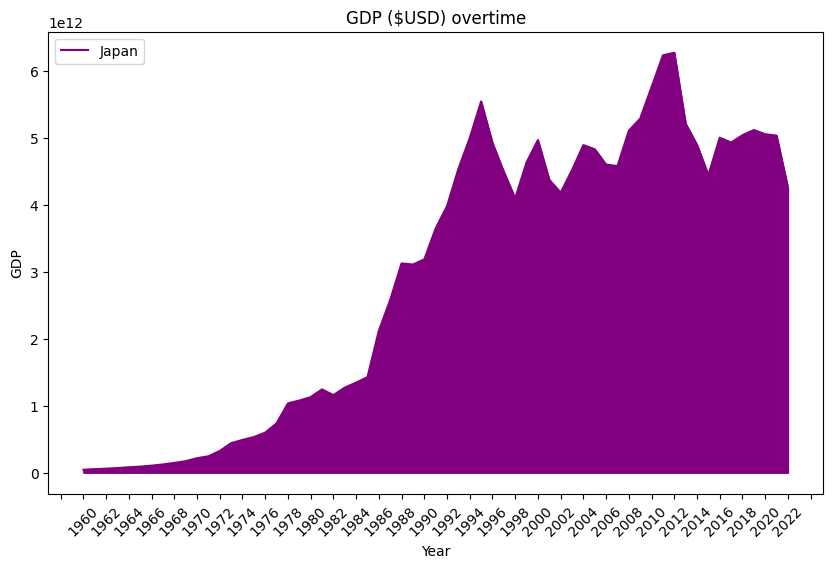

In [122]:
# Plotting a stream graph to display historical series on GDP for major advanced economies

# set the figure sizes
plt.figure(figsize=(10, 6))

# set the line settings for each country's data
plt.plot(dfYX["Year"], dfYX["GDP"], linestyle="-", label="Japan", color="#800080")

# fill the underlying area with color
plt.fill_between(dfYX["Year"], dfYX["GDP"], color="#800080", alpha=1)

# reduce tick frequency on the horizontal axis, in order to better visualize our time coordinates
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(2)) 

# adjust various additional settings to customize the graph
plt.title("GDP ($USD) overtime")
plt.xlabel("Year")
plt.ylabel("GDP")
plt.xticks(rotation=45) 
plt.legend(loc="upper left")
plt.show()


In [107]:
# Include other countries in the graph
# https://wits.worldbank.org/wits/wits/witshelp/content/codes/country_codes.htm

# 0) World (WLD)
dfYWLD = wb.data.DataFrame("NY.GDP.MKTP.CD", "WLD").transpose()
dfYWLD1 = dfYWLD.rename(columns={"WLD": "GDP"})
dfYWLD1.reset_index(inplace=True) 
dfYWLD1.rename(columns={"index": "Year"}, inplace=True) 
dfYWLD1["Year"] = dfYWLD1["Year"].str.slice(start=2) 
dfYWLDX = dfYWLD1
print(dfYWLDX)

# 1) USA (USA)
dfYUSA = wb.data.DataFrame("NY.GDP.MKTP.CD", "USA").transpose()
dfYUSA1 = dfYUSA.rename(columns={"USA": "GDP"})
dfYUSA1.reset_index(inplace=True) 
dfYUSA1.rename(columns={"index": "Year"}, inplace=True) 
dfYUSA1["Year"] = dfYUSA1["Year"].str.slice(start=2) 
dfYUSAX = dfYUSA1
print(dfYUSAX)

# 2) UK (GBR)
dfYGBR = wb.data.DataFrame("NY.GDP.MKTP.CD", "GBR").transpose()
dfYGBR1 = dfYGBR.rename(columns={"GBR": "GDP"})
dfYGBR1.reset_index(inplace=True) 
dfYGBR1.rename(columns={"index": "Year"}, inplace=True) 
dfYGBR1["Year"] = dfYGBR1["Year"].str.slice(start=2) 
dfYGBRX = dfYGBR1
print(dfYGBRX)

# 3) China (CHN)
dfYCHN = wb.data.DataFrame("NY.GDP.MKTP.CD", "CHN").transpose()
dfYCHN1 = dfYCHN.rename(columns={"CHN": "GDP"})
dfYCHN1.reset_index(inplace=True) 
dfYCHN1.rename(columns={"index": "Year"}, inplace=True) 
dfYCHN1["Year"] = dfYCHN1["Year"].str.slice(start=2) 
dfYCHNX = dfYCHN1
print(dfYCHNX)

# 4) Italy (ITA)
dfYITA = wb.data.DataFrame("NY.GDP.MKTP.CD", "ITA").transpose()
dfYITA1 = dfYITA.rename(columns={"ITA": "GDP"})
dfYITA1.reset_index(inplace=True) 
dfYITA1.rename(columns={"index": "Year"}, inplace=True) 
dfYITA1["Year"] = dfYITA1["Year"].str.slice(start=2) 
dfYITAX = dfYITA1
print(dfYITAX)

# 5) Germany (DEU)
dfYDEU = wb.data.DataFrame("NY.GDP.MKTP.CD", "DEU").transpose()
dfYDEU1 = dfYDEU.rename(columns={"DEU": "GDP"})
dfYDEU1.reset_index(inplace=True) 
dfYDEU1.rename(columns={"index": "Year"}, inplace=True) 
dfYDEU1["Year"] = dfYDEU1["Year"].str.slice(start=2) 
dfYDEUX = dfYDEU1
print(dfYDEUX)


economy  Year           GDP
0        1960  1.381135e+12
1        1961  1.446356e+12
2        1962  1.546369e+12
3        1963  1.670666e+12
4        1964  1.832616e+12
..        ...           ...
58       2018  8.654268e+13
59       2019  8.777740e+13
60       2020  8.527268e+13
61       2021  9.715318e+13
62       2022  1.008796e+14

[63 rows x 2 columns]
economy  Year           GDP
0        1960  5.433000e+11
1        1961  5.633000e+11
2        1962  6.051000e+11
3        1963  6.386000e+11
4        1964  6.858000e+11
..        ...           ...
58       2018  2.053306e+13
59       2019  2.138098e+13
60       2020  2.106047e+13
61       2021  2.331508e+13
62       2022  2.543970e+13

[63 rows x 2 columns]
economy  Year           GDP
0        1960  7.323397e+10
1        1961  7.774197e+10
2        1962  8.124756e+10
3        1963  8.656196e+10
4        1964  9.440756e+10
..        ...           ...
58       2018  2.871340e+12
59       2019  2.851407e+12
60       2020  2.697807e+12
61

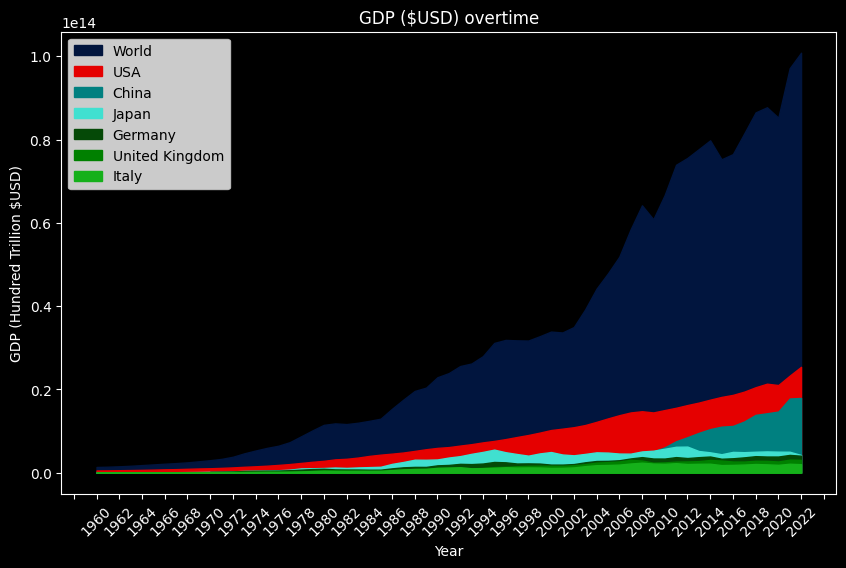

In [173]:
# Modify the original stream graph by including multiple economies
# https://matplotlib.org/stable/users/explain/colors/colors.html 

plt.figure(figsize=(10, 6))

# Set the graph for each economy
plt.fill_between(dfYWLDX["Year"], dfYWLDX["GDP"], color="#01153E", alpha=1, label="World")
plt.fill_between(dfYUSAX["Year"], dfYUSAX["GDP"], color="#E50000", alpha=1, label="USA")
plt.fill_between(dfYCHNX["Year"], dfYCHNX["GDP"], color="#008080", alpha=1, label="China")
plt.fill_between(dfYX["Year"], dfYX["GDP"], color="#40E0d0", alpha=1, label="Japan")
plt.fill_between(dfYDEUX["Year"], dfYDEUX["GDP"], color="#054907", alpha=1, label="Germany")
plt.fill_between(dfYGBRX["Year"], dfYGBRX["GDP"], color="#008000", alpha=1, label="United Kingdom")
plt.fill_between(dfYITAX["Year"], dfYITAX["GDP"], color="#15B01A", alpha=1, label="Italy")

# reduce tick frequency on the horizontal axis, in order to better visualize our time coordinates
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(2)) 

# adjust various additional settings to customize the graph
plt.title("GDP ($USD) overtime")
plt.xlabel("Year")
plt.ylabel("GDP (Hundred Trillion $USD)")
plt.xticks(rotation=45) 
plt.style.use("default")
plt.legend(loc="upper left")
plt.show()


##### 2) Imports-Yen-USD spot exchange rate 

In [115]:
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

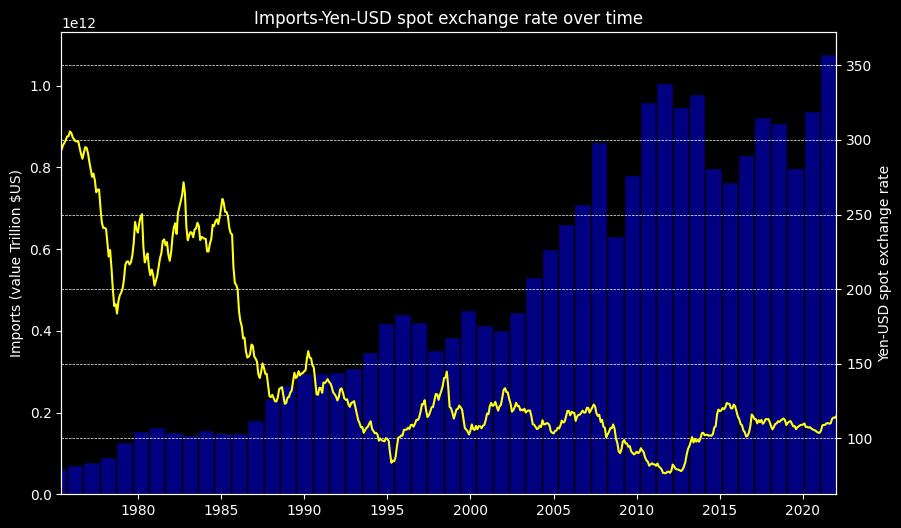

In [172]:
# Plotting a cross-type graph to display the natural correlation between imports and currency appreciation for the Japanese economy

# set the histogram settings for Imports 
# Discretize data into yearly bins
fig, ax1 = plt.subplots(figsize=(10, 6))

dfTIX["Year"] = pd.to_datetime(dfTIX["Year"])
plt.hist(dfTIX["Year"], bins=dfTIX["Year"].nunique(), weights=dfTIX["Imports of goods and services (value $US)"], color="#000080", edgecolor="black")

plt.xlim(1970, dfTIX["Year"].max())
ax1.set_ylabel("Imports (value Trillion $US)")

# set the line settings for Yen-USD spot exchange rate
# in this way we create a line graph to overlap over the previous one
ax2 = ax1.twinx()

ax2.plot(dfyenX["Month"], dfyenX["Yen"], linestyle="-", color="#FFFF14")

ax2.set_xlabel("Month")
ax2.set_ylabel("Yen-USD spot exchange rate")
ax2.grid(True, linestyle="--", linewidth=0.5, color="white")

# general settings
plt.title("Imports-Yen-USD spot exchange rate over time")
plt.style.use("dark_background")
plt.show()

### **Open-AI plug-in**

In [216]:
import requests
from bs4 import BeautifulSoup
import openai
from openai import OpenAI

In [337]:
# Program structure

# to check program credit usage
# https://platform.openai.com/usage

# Set up OpenAI API key
# DISCLAIMER: the so API key is strictly personal and you should refrain from sharing it with strangers
# you can generate an API key on https://help.openai.com/en/articles/4936850-where-do-i-find-my-openai-api-key by registrating a valid account and adding some credit 
# OpenAI API key-example: OPENAIKEY  
openai.api_key = "OPENAIKEY"


##### 1) Base form

In [338]:
# 1) Function to retrieve articles related to a specific topic from the internet and returns a list of article URLs.
def get_articles(topic):

    # Customize this function to scrape articles from preferred sources
    if topic == "Japan's GDP":
        url = "https://japannews.yomiuri.co.jp/news-services/reuters/20240312-174036/"
    elif topic == "Interest rates in Japan":
        url = "https://www.asahi.com/ajw/articles/15194959"
    elif topic == "Inflation rate in Japan":
        url = "https://mainichi.jp/english/articles/20240311/p2g/00m/0bu/011000c"
    else:
        raise ValueError("Invalid topic")
    
    return url

In [267]:
# 2) Function to create a summary out of an article using ChatGPT
# https://github.com/openai/openai-python/blob/main/src/openai/types/chat/completion_create_params.py 

# here we include in a new function our previous output (article_urls) as a parameter
def summarize_article(article_url):

    # Fetch article content (the "response" function takes the HTML text from the URL)
    response = requests.get(article_url)
    soup = BeautifulSoup(response.content, "html.parser")
    article_text = soup.get_text()

    # Summarize using ChatGPT
    MODEL = "gpt-3.5-turbo"
    prompt = f"You are working for the Bank of Italy (Asia-Pacific delegation) and you are ask to summarize the following article in less than 30 words (mandatory), as part of a daily economic report on the Asia-Pacific area (in British English):\n{article_text}"
    summary = openai.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens = 20
    )
    return summary

In [263]:
# RESULT-Base from model
# topic-example: Japan's GDP

# print(summarize_article(get_articles("Japan's GDP")))

##### 2) Advanced form

In [286]:
import requests
from bs4 import BeautifulSoup
import openai
from openai import OpenAI
from datetime import datetime, timedelta

In [335]:
def get_articles1(topic):

    # Customize the function to scrape articles from your preferred sources
    # Set sources
    # URL-journal-examples: https://japannews.yomiuri.co.jp, 

    urls = [f"https://japannews.yomiuri.co.jp/?s={topic}", f"https://www.asahi.com/ajw/search/results/?keywords={topic}"]
    article_urls = []

    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        print("Scraping URL:", url)

    # Date settings (days=how many days you want to go back in the past starting from today)
        today = datetime.today()
        day = today - timedelta(days = 0)
        day_date = day.strftime("%Y%m%d")
        DD_day_date = day.strftime("%d")
        print(day_date, DD_day_date)

    # if you want "today()" date: 
    ## today_date = datetime.today().strftime("%Y%m%d")
    # or you may set days = 0

    # Find and extract article URLs
        for link in soup.find_all("a", href=True):
            #if len(article_urls) >= 5:  # Limit to the first five articles
                #break
            article_url = link["href"]
            print("Found link:", article_url)
    
    # Filter out non-article URLs (e.g., navigation links) and keep only those article that has been published 
        if url.startswith("https://japannews.yomiuri.co.jp"):
            if article_url.startswith(f"https://japannews.yomiuri.co.jp/business/economy/{day_date}-"):
                article_urls.append(article_url)
                
        elif url.startswith("https://www.asahi.com"):
            if  article_url.startswith(f"/ajw/articles/{DD_day_date}"):   
                article_urls.append(article_url)
            
    return article_urls

In [336]:
japan_inflation = "japan+inflation+rate"
topic = japan_inflation

print(get_articles1(topic))

Scraping URL: https://japannews.yomiuri.co.jp/?s=japan+inflation+rate
20240315 15
Found link: #
Found link: #
Found link: https://japannews.yomiuri.co.jp
Found link: https://www.yomiuri.co.jp/
Found link: #
Found link: https://japannews.yomiuri.co.jp/myaccount
Found link: javascript:void(0);
Found link: javascript:void(0);
Found link: javascript:void(0);
Found link: javascript:void(0);
Found link: https://japannews.yomiuri.co.jp/myaccount
Found link: javascript:void(0);
Found link: https://japannews.yomiuri.co.jp/myaccount
Found link: javascript:void(0);
Found link: https://japannews.yomiuri.co.jp
Found link: https://japannews.yomiuri.co.jp/latestnews/
Found link: https://japannews.yomiuri.co.jp/politics/
Found link: https://japannews.yomiuri.co.jp/politics/politics-government/
Found link: https://japannews.yomiuri.co.jp/politics/defense-security/
Found link: https://japannews.yomiuri.co.jp/politics/election/
Found link: https://japannews.yomiuri.co.jp/politics/political-series/
Found 

In [199]:
# 1) Function to retrieve articles related to a specific topic from the internet and returns a list of article URLs.
def get_articles(topic):

    # Customize this function to scrape articles from preferred sources
    if topic == "Japan's GDP":
        url = "https://asia.nikkei.com/Economy/Japan-avoids-recession-as-strong-capex-boosts-Q4-GDP"
    elif topic == "Interest rates in Japan":
        url = "https://www.asahi.com/ajw/articles/15194959"
    elif topic == "Inflation rate in Japan":
        url = "https://mainichi.jp/english/articles/20240311/p2g/00m/0bu/011000c"
    else:
        raise ValueError("Invalid topic")
    
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the first article URL associated with the topic
    article_link = soup.find("a", href=True)
    if article_link:
        article_url = article_link["href"]
        print("Found article URL:", article_url)
        return article_url
    else:
        print("No article URL found.")
        return None

    # Find and extract article URLs
    # article_url = soup.find("a", href=True)["href"]
    # article_urls = [link["href"] for link in soup.find_all("a", href=True)]
    #return article_url

In [260]:
# 2) Function to create a summary out of an article using ChatGPT
# https://github.com/openai/openai-python/blob/main/src/openai/types/chat/completion_create_params.py 

# here we include in a new function our previous output (article_urls) as a parameter
def summarize_article(article_url):

    # Fetch article content (the "response" function takes the HTML text from the URL)
    response = requests.get(article_url)
    soup = BeautifulSoup(response.content, "html.parser")
    article_text = soup.get_text()

    # Summarize using ChatGPT
    MODEL = "gpt-3.5-turbo"
    prompt = f"You are working for the Bank of Italy (Asia-Pacific delegation) and you are ask to summarize the following article in less than 30 words (mandatory), as part of a daily economic report on the Asia-Pacific area (in British English):\n{article_text}"
    summary = openai.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens = 20
    )
    return summary

In [207]:
# 3) Main function to summarize articles on specified topics
def main(topics):

    summarized_info = {}

    # for each topic, we retrieve its respective url
    for topic in topics:
        articles = get_articles(topic)
        summarized_info[topic] = []

    # for each url, we retrieve its respective summary
        for article_url in articles:
            summary = summarize_article(article_url)

            # we want to include in output both the source and its respective summary
            summarized_info[topic].append({
                "source": article_url,
                "summary": summary
            })
    return summarized_info

if __name__ == "__main__":

    # List of topics to search for articles
    topics = ["Inflation rate in Japan", "Interest rates in Japan", "Japan's GDP"]
    summarized_info = main(topics)
    print(summarized_info)